In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

# new:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

Take the data from Lino's preprocessing script

In [66]:
X = pd.read_csv('data/X.csv')
y = pd.read_csv('data/y.csv')

In [67]:
print("X info:")
X.info()
print("\n y info:")
y.info()

X info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76822 entries, 0 to 76821
Columns: 495 entries, age to job_end_2019
dtypes: bool(259), float64(236)
memory usage: 157.3 MB

 y info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76822 entries, 0 to 76821
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sphus   76822 non-null  int64
dtypes: int64(1)
memory usage: 600.3 KB


In [68]:
y.head

<bound method NDFrame.head of        sphus
0          1
1          0
2          0
3          0
4          0
...      ...
76817      0
76818      0
76819      0
76820      0
76821      0

[76822 rows x 1 columns]>

OK, need to convert this to numeric to make it into tensor (later will need to map it back to categorical to get meaningful answers)

In [69]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y['sphus'] = label_encoder.fit_transform(y['sphus'])
print(y)

       sphus
0          1
1          0
2          0
3          0
4          0
...      ...
76817      0
76818      0
76819      0
76820      0
76821      0

[76822 rows x 1 columns]


In [70]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# train is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state = 123)

# test is now 15% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio / (test_ratio + validation_ratio), random_state = 10117)

n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]
n = n_train + n_val + n_test

print((n_train / n), (n_val / n), (n_test / n)) 

0.6999947931582099 0.14999609486865742 0.15000911197313269


In [71]:
# Check for NaNs in the training data
if X_train.isna().any().any() or y_train.isna().any().any():
    print("NaNs in train data")
else:
    print("No NaNs in train data")

# Check for infinities in the training data
if (X_train == np.inf).any().any() or (y_train == np.inf).any().any():
    print("Infinities in train data")
else:
    print("No Infinities in train data")

No NaNs in train data
No Infinities in train data


# Impute & scale

In [72]:
# IMPUTING:

# create copies of original
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()
X_val_imputed = X_val.copy()

# non numeric
# Select non-numeric columns (booleans)
non_numeric_columns_train = X_train_imputed.select_dtypes(include=['object', 'bool']).columns
non_numeric_columns_test = X_test_imputed.select_dtypes(include=['object', 'bool']).columns
non_numeric_columns_val = X_val_imputed.select_dtypes(include=['object', 'bool']).columns


# Impute non-numeric columns with the string "missing"
X_train_imputed[non_numeric_columns_train] = X_train_imputed[non_numeric_columns_train].fillna("missing")
X_test_imputed[non_numeric_columns_test] = X_test_imputed[non_numeric_columns_test].fillna("missing")
X_val_imputed[non_numeric_columns_val] = X_val_imputed[non_numeric_columns_val].fillna("missing")


# numeric
# Select numeric columns
numeric_columns_train = X_train_imputed.select_dtypes(include=[np.number]).columns
numeric_columns_test = X_test_imputed.select_dtypes(include=[np.number]).columns
numeric_columns_val = X_val_imputed.select_dtypes(include=[np.number]).columns

# Initialize the imputer for numeric columns
numeric_imputer = SimpleImputer(strategy='mean')

# Apply imputation to numeric columns in training data (fit & transform)
X_train_imputed[numeric_columns_train] = numeric_imputer.fit_transform(X_train_imputed[numeric_columns_train])

# Apply imputation to numeric columns in testing / val data using the *same* imputer (only transform)
X_test_imputed[numeric_columns_test] = numeric_imputer.transform(X_test_imputed[numeric_columns_test])
X_val_imputed[numeric_columns_val] = numeric_imputer.transform(X_val_imputed[numeric_columns_val])


In [73]:
# SCALING

# initialise
scaler = StandardScaler()

# Scale training data (fit and transform)
X_train_imputed_scaled = X_train_imputed.copy()
X_train_imputed_scaled[numeric_columns_train] = scaler.fit_transform(X_train_imputed[numeric_columns_train])

# Scale testing & validation data (only transform)
X_test_inputed_scaled = X_test_imputed.copy()
X_test_inputed_scaled[numeric_columns_test] = scaler.transform(X_test_imputed[numeric_columns_test])

X_val_imputed_scaled = X_val_imputed.copy()
X_val_imputed_scaled[numeric_columns_test] = scaler.transform(X_val_imputed[numeric_columns_test])

# Convert to Tensors

In [74]:

# Convert feature DataFrames to NumPy arrays and then to tensors
X_train_torch = torch.tensor(X_train_imputed_scaled.to_numpy().astype(np.float32))
X_val_torch = torch.tensor(X_val_imputed_scaled.to_numpy().astype(np.float32))
X_test_torch = torch.tensor(X_test_inputed_scaled.to_numpy().astype(np.float32))

# Convert label Series to tensors and unsqueeze to add an extra dimension
y_train_torch = torch.tensor(y_train.to_numpy().astype(np.float32)).unsqueeze(1)
y_val_torch = torch.tensor(y_val.to_numpy().astype(np.float32)).unsqueeze(1)
y_test_torch = torch.tensor(y_test.to_numpy().astype(np.float32)).unsqueeze(1)


since we're doing classification we do NOT need to scale the y-label series.

In [75]:
# DataLoader instances

# Ensure targets are Long tensors and 1D
# needs to be 'long' for categorical, where loss functions that expect integer labels
# .view(-1) reshapes a tensor: -1 is placeholder for an unknown dimension which PyTorch infers based on the other dimensions. 
# # So .view(-1) flattens  tensor into a 1-D tensor.
train_dataset = TensorDataset(X_train_torch, y_train_torch.long().view(-1)) 
val_dataset = TensorDataset(X_val_torch, y_val_torch.long().view(-1))
test_dataset = TensorDataset(X_test_torch, y_test_torch.long().view(-1))

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


below: had errors with targets being out of bound, this just asserts they are all within bound

In [76]:
try:
    # number of output classes required
    num_classes = len(torch.unique(y_train_torch))

    # etrainsure all target values are within the valid range
    assert torch.all((y_train_torch >= 0) & (y_train_torch < num_classes)), "Train targets out of range"
    assert torch.all((y_val_torch >= 0) & (y_val_torch < num_classes)), "Validation targets out of range"
    assert torch.all((y_test_torch >= 0) & (y_test_torch < num_classes)), "Test targets out of range"
    print("All OK")
except AssertionError as e:
    print(e)

All OK


# Write functions for full workflow

### 1) A function to train the model over one epoch

In [77]:
def train_one_epoch(train_loader, model, loss_fn, optimizer):
    model.train()  
    total_loss = 0.0
    
    for batch in train_loader:
        inputs, targets = batch
        
        # ensure targets are Long tensor and 1D (already done this, this is robustness check)
        targets = targets.long().view(-1)
        
        optimizer.zero_grad()  # zero previous gradients

        # forward pass: compute model output
        outputs = model(inputs)
        
        # compute loss
        loss = loss_fn(outputs, targets)

        # Backward pass: compute gradient of loss wrt to model params
        loss.backward()  # Backpropagation
        
        # Update the model parameters
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

    # Return the average loss for this epoch
    average_loss = total_loss / len(train_loader)
    return average_loss


### 2) A function to evaluate error on entire val / test set


In [78]:
def evaluate_model(data_loader, model, loss_fn):
    model.eval()  
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient computation during evaluation
        for batch in data_loader:
            inputs, targets = batch

            # ensure targets are Long tensor and 1D (again, already done, but this is robustness check)
            targets = targets.long().view(-1)

            # forward pass
            outputs = model(inputs)
            
            # compute loss
            loss = loss_fn(outputs, targets)

            # aggregate the loss
            total_loss += loss.item()
            
    # return average loss for the entire dataset
    average_loss = total_loss / len(data_loader) 
    return average_loss


### 3) A function to integrate training and validation, returning the best model

In [79]:
def train_and_validate(train_loader, val_loader, model, epochs, optimizer, loss_fn):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Train the model for one epoch
        train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
        train_losses.append(train_loss)

        # Evaluate the model on the validation set
        val_loss = evaluate_model(val_loader, model, loss_fn)
        val_losses.append(val_loss)

        # Check if this is the smallest so far and save associated model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        #print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Load the best model state
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

### 4) A function to get predictions from a given model

In [80]:
def get_predictions(model, data_loader):
    model.eval()  # met model to evaluation mode
    predictions = []

    with torch.no_grad():  # again disable gradient computation
        for inputs, _ in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            predictions.extend(predicted.cpu().numpy())  # Convert to numpy array and extend the list
    
    return np.array(predictions)  # Convert the list to a numpy array

### 4) A function to produce classification report

In [81]:
from sklearn.metrics import classification_report

def generate_classification_report(model, test_loader):
    predictions = get_predictions(model, test_loader)
    
    # Extract true labels from test_loader
    true_labels = []
    for _, targets in test_loader:
        true_labels.extend(targets.cpu().numpy())
    
    # Generate and print classification report with zero_division handling        
    report = classification_report(
        true_labels, predictions, target_names=[str(cls) for cls in label_encoder.classes_], zero_division=0 # need to make target names into string
    )
    print(f"\n Classification Report for {model.name}:")
    print(report)
    
    return report

### 5) A final workflow function - brings it all together

In [82]:
def run_workflow(models, train_loader, val_loader, test_loader, epochs=20):
    best_val_loss = float('inf')
    best_model = None
    results = []

    for model in models:
        print(f"\n Training model: {model.name}")
        
        # Define loss function and optimizer 
        loss_fn = nn.CrossEntropyLoss() # necessary for categorical y variable
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train and validate the model
        trained_model, train_losses, val_losses = train_and_validate(
            train_loader, val_loader, model, epochs, optimizer, loss_fn
        )

        # Evaluate on the test set
        test_loss = evaluate_model(test_loader, trained_model, loss_fn)
        
        classification_report_str = generate_classification_report(trained_model, test_loader)
        
        results.append({
            'model_name': model.__class__.__name__,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_loss': test_loss,
            'classification_report': classification_report_str
        })
        
        # Track the best model based on validation loss
        if min(val_losses) < best_val_loss:
            best_val_loss = min(val_losses)
            best_model = trained_model
        
        print(f"Completed training for model: {model.name}")

    return best_model, results


Summary: need to provide following parameters to run_workflow():
- models (a list of instantiated models), 
- train_loader, 
- val_loader, 
- test_loader, 
- (epochs)

and it will return:
- best_model,
- results

# Define Model Architectures

### Basic linear NN

In [83]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.hidden_size = hidden_size  
        self.hidden = nn.Linear(input_features, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_features)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return F.softmax(x, dim=1)

### Deep Model:

- Batch normalization helps in normalising  inputs of each layer, reducing internal covariate shift. 
- Same as before: nonlinear ReLU activation function ensures.

In [84]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(DeepNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.output = nn.Linear(128, output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.relu(self.bn3(self.layer3(x)))
        x = self.output(x)
        return x

### Dropout model
- after 1st activation layer, using a dropout rate of 50% to prevent overfitting - works by randomly deactivating half of the output units during training. 
- LeakyReLU: against issue of dying nodes (neurons) through small, positive gradient for negative inputs

In [85]:
class DropoutNeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(DropoutNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 500)
        self.layer2 = nn.Linear(500, 100)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(100, output_features)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer2(x))
        x = self.output(x)
        return x

### Combo Model

- integrates both dropout regularization and batch normalization across three layers 
- intended to enhance training stability and prevent overfitting
- employs Leaky ReLU as the activation function again to ensure consistent small gradients

In [86]:
class CombinedNeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(CombinedNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.25)  # Moderate dropout
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.25)
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.output = nn.Linear(128, output_features)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.dropout1(self.leaky_relu(self.bn1(self.layer1(x))))
        x = self.dropout2(self.leaky_relu(self.bn2(self.layer2(x))))
        x = self.leaky_relu(self.bn3(self.layer3(x)))
        x = self.output(x)

        return x

### Mixed Activation Functions

- uses different activation functions at different layers to capture different types of nonlinear relationships at various levels of abstraction
-  idea is to enable the model to learn more *diverse* representations by varying the transformations applied to inputs / intermediate features.

In [87]:
class MixedActivationNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(MixedActivationNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 128)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.layer3 = nn.Linear(128, 64)
        self.elu = nn.ELU()
        self.output_layer = nn.Linear(64, output_features)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.leaky_relu(self.layer2(x))
        x = self.elu(self.layer3(x))
        x = self.output_layer(x)
        return x

### ResNet

"Employs principles of a Residual Network (ResNet) architecture adapted for regression tasks. It is designed with an initial linear block to project input features into a 64-dimensional space, followed by a series of residual blocks that apply transformations and integrate the original input via skip connections to enhance learning without degradation, culminating with a final linear layer to produce a scalar output"

- main point: residual blocks enable deeper networks by adding shortcut connections that bypass one or more layers, aiming to address the problem of vanishing gradients in deep neural networks

In [88]:
# build module
class ResidualBlock(nn.Module):
    def __init__(self, input_features, output_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_features, output_features)
        self.bn1 = nn.BatchNorm1d(output_features)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(output_features, output_features)
        self.bn2 = nn.BatchNorm1d(output_features)

    def forward(self, x):
        identity = x
        out = self.linear1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.bn2(out)

        out += identity  
        out = self.relu(out)

        return out
    

# build model
class ResNetRegression(nn.Module):
    def __init__(self, input_features, block, num_blocks, output_features=1):
        super(ResNetRegression, self).__init__()
        self.num_blocks = num_blocks
        self.input_features = input_features
        self.current_features = 64  # here is initial number of features
        self.init_block = nn.Sequential(
            nn.Linear(input_features, self.current_features),
            nn.BatchNorm1d(self.current_features),
            nn.ReLU(inplace=True)
        )
        self.blocks = self._make_layer(block, 64, num_blocks)
        self.final_layer = nn.Linear(64, output_features)

    def _make_layer(self, block, output_features, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.current_features, output_features))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.init_block(x)
        x = self.blocks(x)
        x = self.final_layer(x)
        return x

### Dynamic Routing Network

idea is a "routing" mechanism that dynamically decides how much of each layer's output should contribute to the next layer's input.

- uses gating layers to selectively control the flow of information through the network by multiplying the output of a linear transformation of the input (x_transformed) by a gating signal (gate). 
- gating mechanism is a sigmoid function, which scales the linearly transformed input before passing it through gated layers
- as before, residual blocks enable deeper networks by adding shortcut connections that bypass one or more layers, aiming to address the problem of vanishing gradients in deep neural networks

In [89]:
# build module 
class GatingLayer(nn.Module):
    def __init__(self, input_features, output_features):
        super(GatingLayer, self).__init__()
        self.layer = nn.Linear(input_features, output_features)
        self.gate = nn.Sequential(
            nn.Linear(input_features, output_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_transformed = self.layer(x)
        gate = self.gate(x)
        return x_transformed * gate

# build model
class DynamicRoutingNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(DynamicRoutingNetwork, self).__init__()
        self.layer1 = GatingLayer(input_features, 128)
        self.layer2 = GatingLayer(128, 64)
        self.layer3 = GatingLayer(64, 64)
        self.output_layer = nn.Linear(64, output_features)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

# Initialise Models

Function for automatically naming models

In [90]:
def model_name(models):
     model_names = []
     for model in models:
         try:
             name = f"{model.__class__.__name__} with {model.hidden_size} hidden nodes"
         except AttributeError:
             #  where hidden_nodes attribute is not available
             name = f"{model.__class__.__name__}"
        
         # set the name attribute
         model.name = name
         model_names.append(name)
     return model_names

Instantiate!!

In [91]:
input_features = X_train_torch.shape[1]
output_features = num_classes  

base_nn_10 = NeuralNetwork(input_features=input_features, output_features=output_features, hidden_size=10)
base_nn_100 = NeuralNetwork(input_features=input_features, output_features=output_features, hidden_size=100)
deep_model = DeepNeuralNetwork(input_features=input_features, output_features=output_features)
dropout_model = DropoutNeuralNetwork(input_features=input_features, output_features=output_features,)
combo_model = CombinedNeuralNetwork(input_features=input_features, output_features=output_features,)
mixed_model = MixedActivationNetwork(input_features=input_features, output_features=output_features,)
ResNet_model = ResNetRegression(input_features=input_features, output_features=output_features, block=ResidualBlock, num_blocks=3)
routing_model = DynamicRoutingNetwork(input_features=input_features, output_features=output_features)

models = [
    base_nn_10,
    base_nn_100,
    deep_model,
    dropout_model,
    combo_model,
    mixed_model,
    ResNet_model,
    routing_model
]
model_name(models)

['NeuralNetwork with 10 hidden nodes',
 'NeuralNetwork with 100 hidden nodes',
 'DeepNeuralNetwork',
 'DropoutNeuralNetwork',
 'CombinedNeuralNetwork',
 'MixedActivationNetwork',
 'ResNetRegression',
 'DynamicRoutingNetwork']

# Run Comparative Training & Validating

Reminder: need to provide following parameters to run_workflow():
Summary: need to provide following parameters to run_workflow():
- models (a list of models) 
- train_loader, 
- val_loader, 
- test_loader, 
- (epochs)

and it will return:
- best_model,
- results

In [92]:
# Run  !!!
best_model, results = run_workflow(models, train_loader, val_loader, test_loader, epochs=20)


 Training model: NeuralNetwork with 10 hidden nodes

 Classification Report for NeuralNetwork with 10 hidden nodes:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10064
           1       0.68      0.43      0.53      1460

    accuracy                           0.90     11524
   macro avg       0.80      0.70      0.74     11524
weighted avg       0.89      0.90      0.89     11524

Completed training for model: NeuralNetwork with 10 hidden nodes

 Training model: NeuralNetwork with 100 hidden nodes

 Classification Report for NeuralNetwork with 100 hidden nodes:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     10064
           1       0.64      0.47      0.54      1460

    accuracy                           0.90     11524
   macro avg       0.78      0.72      0.74     11524
weighted avg       0.89      0.90      0.89     11524

Completed training for model: NeuralNetwork w

In [93]:
# Print results summary
for result in results:
    print(f"Model: {result['model_name']}")
    print(f"Test Loss: {result['test_loss']:.4f}")
    print(f"Classification Report:\n{result['classification_report']}")

Model: NeuralNetwork
Test Loss: 0.4061
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10064
           1       0.68      0.43      0.53      1460

    accuracy                           0.90     11524
   macro avg       0.80      0.70      0.74     11524
weighted avg       0.89      0.90      0.89     11524

Model: NeuralNetwork
Test Loss: 0.4085
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     10064
           1       0.64      0.47      0.54      1460

    accuracy                           0.90     11524
   macro avg       0.78      0.72      0.74     11524
weighted avg       0.89      0.90      0.89     11524

Model: DeepNeuralNetwork
Test Loss: 0.2318
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10064
           1       0.69      0.46      0.55    

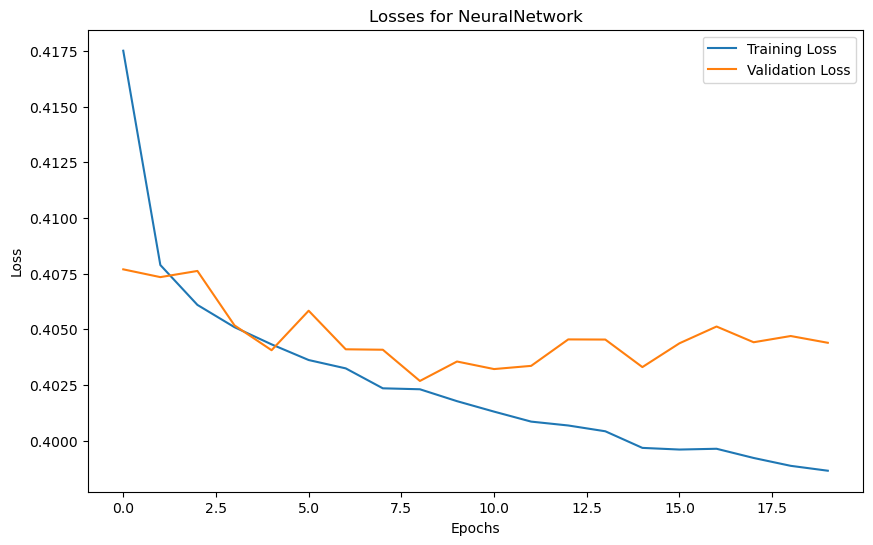

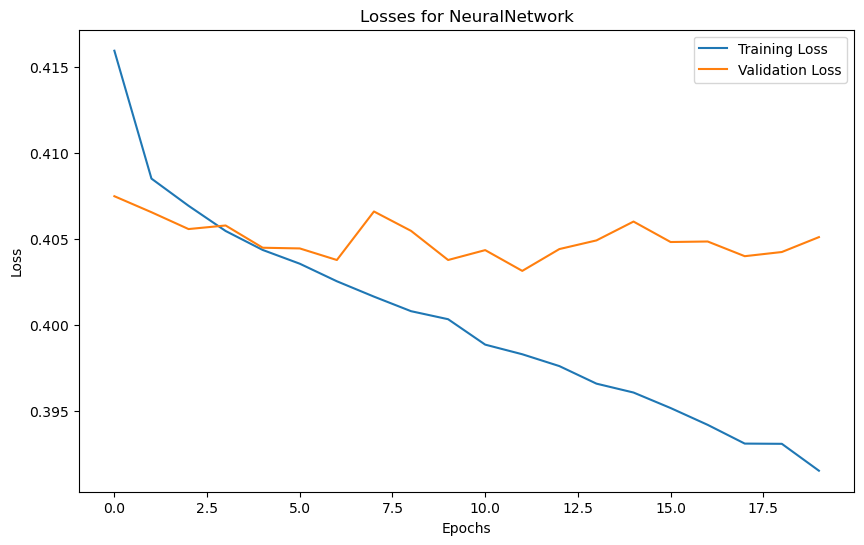

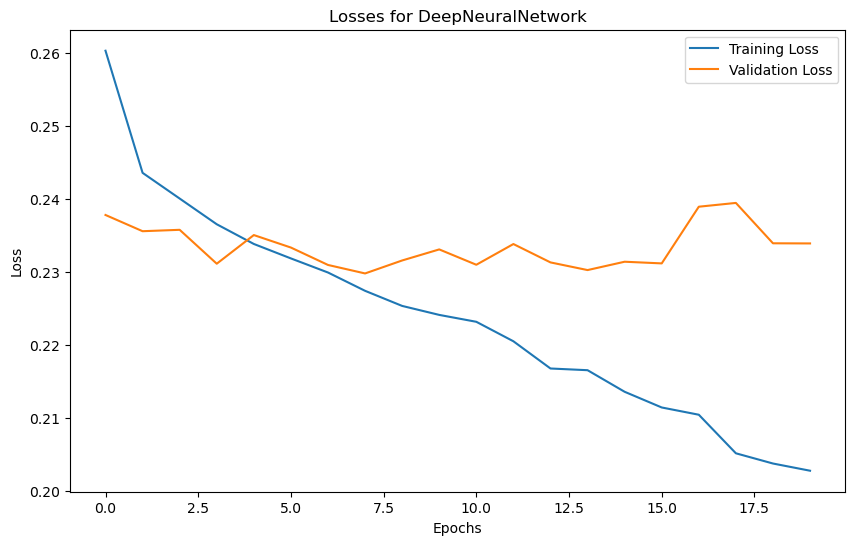

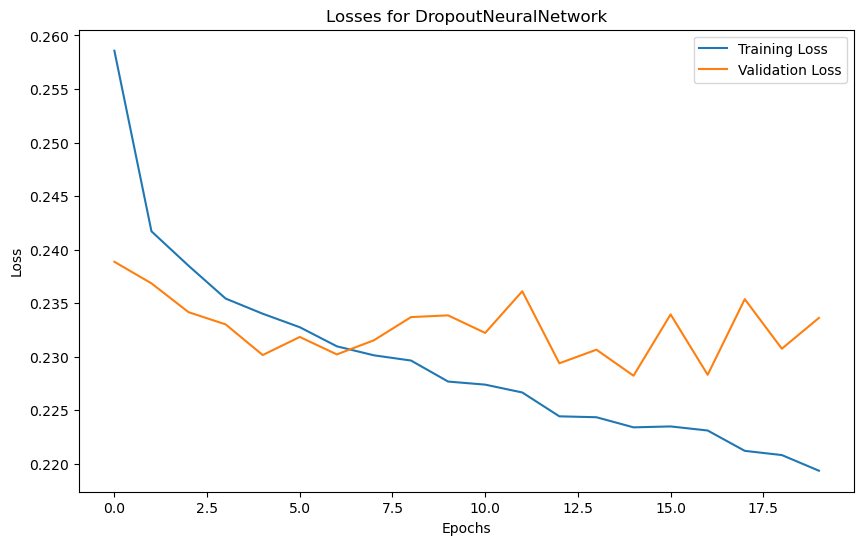

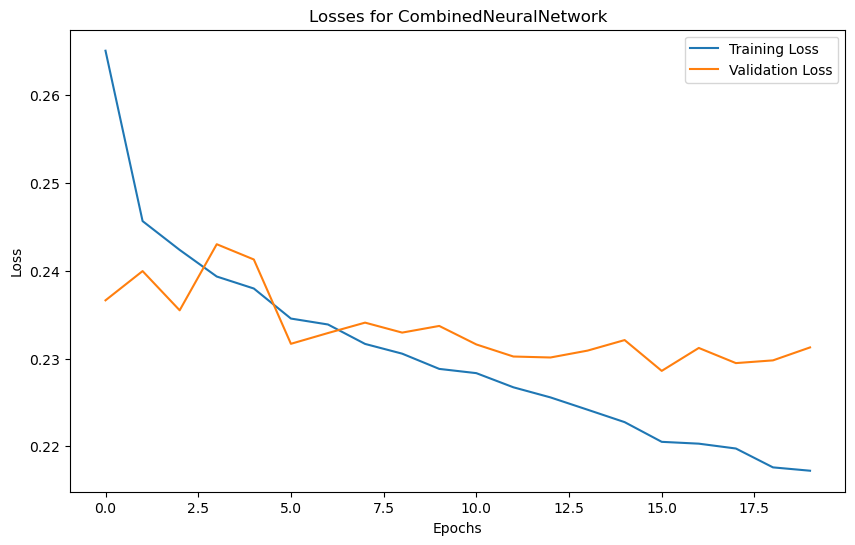

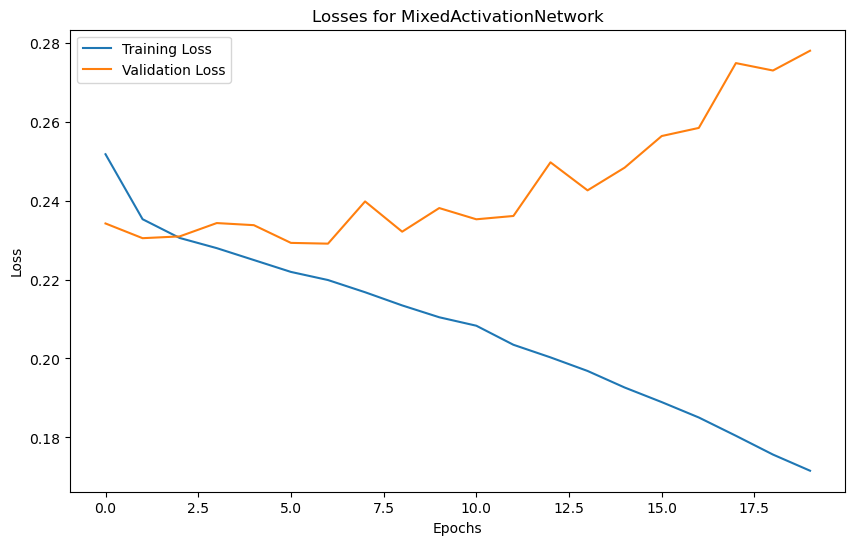

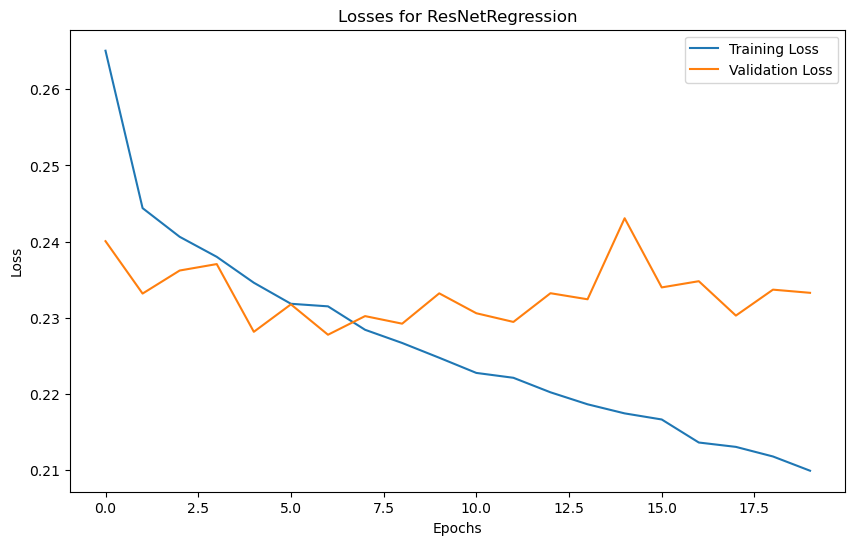

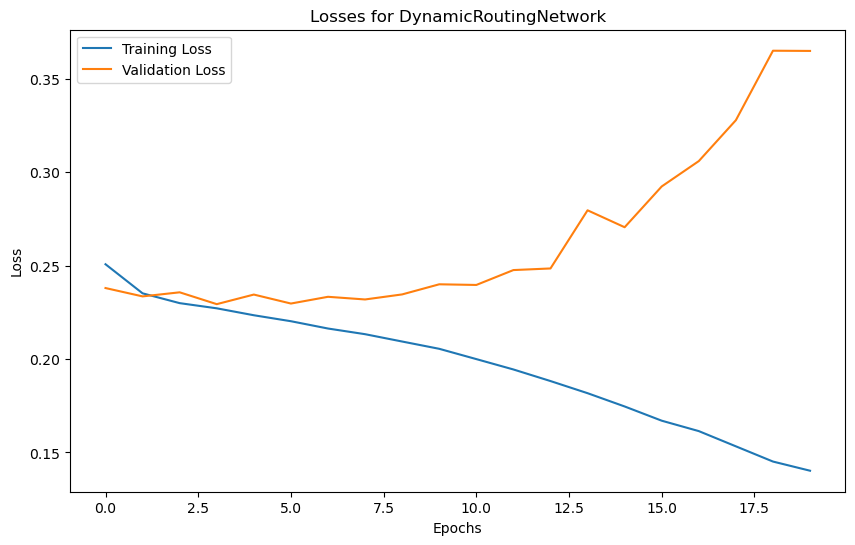

In [98]:

# Function to visualize training vs validation error scores over epochs
def plot_losses(results):
    for result in results:
        plt.figure(figsize=(10, 6))
        plt.plot(result['train_losses'], label='Training Loss')
        plt.plot(result['val_losses'], label='Validation Loss')
        plt.title(f"Losses for {result['model_name']}")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

def choose_best_model(results):
    return min(range(len(results)), key=lambda i: results[i]['test_loss'])


# Visualization of validation errors over epochs
plot_losses(results)


In [101]:
best_model_index = choose_best_model(results)
best_model = results[best_model_index]


best_model


{'model_name': 'CombinedNeuralNetwork',
 'train_losses': [0.26504629196190255,
  0.24564919254206816,
  0.24236807405753621,
  0.23933834130036413,
  0.23797296237583887,
  0.2345523506509343,
  0.2338768323702801,
  0.23166494899867618,
  0.23055628088792118,
  0.22882137225097593,
  0.22833786758105007,
  0.22672610846722077,
  0.22557477180329127,
  0.22417524122566002,
  0.222760313577786,
  0.22051709709087347,
  0.22030846499114928,
  0.2197568373824428,
  0.21760934282810046,
  0.21722840751337905],
 'val_losses': [0.23662861390168316,
  0.23995689707201934,
  0.2354923418085826,
  0.24301547819227393,
  0.24127907400894033,
  0.23167813715842292,
  0.23290454606600416,
  0.23408871015064273,
  0.23295392778152574,
  0.23371191756216772,
  0.23160637065850798,
  0.23023039205747958,
  0.23012034219387825,
  0.23090339569669022,
  0.2321028754920015,
  0.2285959984580896,
  0.23120585593738055,
  0.229481118775058,
  0.22979145428975864,
  0.23126736823005029],
 'test_loss': 0.22